<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-258/blob/master/Assignments/Assignment4/Assignment4_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST Digit classifier using Numpy


In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

Source: [Advance Machine Learning - Coursera](https://github.com/MrinmoiHossain/Advanced-Machine-Learning-Coursera/blob/master/Course_1-Introduction_to_Deep_Learning/Week-2/Excercise/mnist_with_keras.ipynb)

Loss function(Cross entropy)
Softmax Cross entropy is used as we are predicting probabilities

In [2]:
def softmax_cross_entropy(logits, label):
    return - (logits[np.arange(len(logits)), label]) + np.log(np.sum(np.exp(logits), axis=-1))

# gradient
def softmax_cross_entropy_gradient(logits, label):
    one_hot = np.zeros_like(logits)
    one_hot[np.arange(len(logits)), label] = 1
    return (-one_hot + (np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True))) / logits.shape[0]

Base Layer (use it as an interface to build dense layers)

In [3]:
class Layer:
  '''
      Acts as a base layer. 
      Actions performed:
      - Process input to get output - forward function
      - propogate gradients through itself aka backward propogation- backward function

  '''
  def __init__(self):
    pass
  
  def forward(self, X):
    '''
      Takes input data of shape [batch, input_units], returns output data [batch, output_units]
    '''
    return X

  def backward(self, X, output_gradient):
    '''
      Performs backprop step through the layer
    '''
    return np.dot(output_gradient, np.eye(X.shape[1]))

Dense Layer

In [4]:
class DenseLayer(Layer):
  '''
    A fully connected layer in the form of y = Wx + b |(X-input matrix, W-weights, b-bias)  
  '''

  def __init__(self, no_input, no_output, learning_rate):
    super().__init__()
    self.learning_rate = learning_rate
    self.no_input = no_input
    self.no_output = no_output

    self.weights = np.random.randn(no_input, no_output)*0.01  #initialize weights with small random numbers.
    #print(self.weights.shape)
    self.bias = np.zeros(no_output)

  def forward(self, X):
    '''
      perform y = Wx+b 
    '''
    #print(self.weights.shape)
    return np.dot(X, self.weights) + self.bias

  def backward(self, X, output_gradient):
    '''
      Compute backward gradient wrt to Loss, weights and biases
    '''
    grad_input = np.dot(output_gradient, self.weights.T)
    grad_weights = np.dot(X.T, output_gradient)
    grad_bias = np.sum(output_gradient, axis=0)
   
    #update weights and biases
    self.weights = self.weights - self.learning_rate * grad_weights
    self.bias = self.bias - self.bias * grad_bias

    return grad_input


Relu Layer

In [5]:
class Relu(Layer):
  '''
    Class Relu is used to apply non linearity in each element of the network
  '''
  def __init__(self):
    super().__init__()
    pass

  def forward(self, X):
    return np.maximum(X, np.zeros(X.shape))

  def backward(self, X, output_gradient):
    '''
      compute gradient of loss wrt input of Relu layer
    '''
    grad_relu = X > 0
    return output_gradient * grad_relu

Dropout Layer

In [6]:
class Dropout(Layer):
  '''
    drops neurons chosen randomly to avoid overfitting
  '''
  def __init__(self, no_input, no_output, learning_rate):
    super().__init__()
    
    self.learning_rate = learning_rate
    self.no_input = no_input
    self.no_output = no_output    

    variance = np.sqrt(2.0/(no_input + no_output)) 
    self.weights = variance * np.random.randn(no_input, no_output)
    self.bias = np.zeros(no_output)
    

  def forward(self, X):
    '''
      perform y = WX + b
    '''
    return  (X @ self.weights) + self.bias


  def backward(self, X, output_gradient):
    '''
    Compute backward gradient wrt to Loss, weights and biases
    ''' 
    grad_input = np.dot(output_gradient, self.weights.T)
    grad_weights = np.dot(X.T, output_gradient)
    grad_bias = np.sum(output_gradient, axis=0)

    # drop out
    dropout = lambda X: X if np.random.rand() > 0.3 else 0 
    vdrop = np.vectorize(dropout)
    grad_weights = vdrop(grad_weights)*(1/(0.7))
    
    # update weights, bias
    self.weights = self.weights - self.learning_rate * grad_weights
    self.bias = self.bias - self.learning_rate * grad_bias
    return grad_input



Mini Batch gradient Descent

In [7]:
from tqdm.notebook import tqdm

def mini_batch(inputs, targets, batch_size, shuffle=False):
  if shuffle:
    indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batch_size + 1, batch_size)):
      if shuffle:
        expt = indices[start_idx:start_idx + batch_size]
      else:
        expt = slice(start_idx, start_idx + batch_size)
      yield inputs[expt], targets[expt]

Fit and predict Neural Network

In [8]:

def forward(neuralnet, X):
  '''
    for forward propogation
  '''
  activations = []
  #input = X

  for layer in neuralnet:
    X = layer.forward(X)
    activations.append(X)
  return activations

def predict(neuralnet, X):
  '''
    function for computing network predictions
  '''

  return forward(neuralnet, X)[-1].argmax(axis= -1)

def fit(neuralnet, X, y):
  '''
    function for fitting the ona given batch of inputs and outputs
  '''
  layers = forward(neuralnet, X)
  #print('a')
  inputs = [X] + layers
  logits = layers[-1]

  loss = softmax_cross_entropy(logits, y)
  loss_gradient = softmax_cross_entropy_gradient(logits, y)

  grad_output = loss_gradient
  inputs = inputs[:-1]
  for input, layer in zip(inputs[::-1], neuralnet[::-1]):
    grad_output = layer.backward(input, grad_output)
  
  return np.mean(loss)

  

fetching the data

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


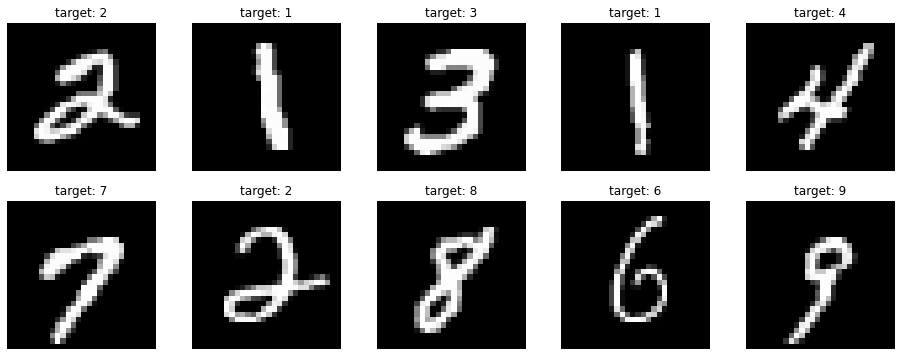

In [10]:
#Viewing the sample images in training datasets:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %5].imshow(X_train[i].reshape((28,28)), cmap='gray');
    axes[i//10, i %5].axis('off')
    axes[i//10, i %5].set_title(f"target: {y_train[i]}")

In [11]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
X_train = X_train/255. 
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])

In [12]:
X_train.shape

(54000, 784)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(54000, 784)
(54000,)
(10000, 28, 28)
(10000,)


In [13]:
#hyperparameters:
num_epochs = 30
learning_rate = 0.1
batch_size = 32

Network without dropout minibatch

In [14]:
#network
network = []
network.append(DenseLayer(X_train.shape[1],100,learning_rate))
network.append(Relu())
network.append(DenseLayer(100, 200,learning_rate))
network.append(Relu())
network.append(DenseLayer(200, 10,learning_rate))

In [15]:
train_log = []
val_log = []



Epoch 0
Train Accuracy: 0.9267222222222222
Test Accuracy: 0.9206666666666666



Epoch 1
Train Accuracy: 0.9644259259259259
Test Accuracy: 0.9585



Epoch 2
Train Accuracy: 0.9726851851851852
Test Accuracy: 0.9655



Epoch 3
Train Accuracy: 0.9817222222222223
Test Accuracy: 0.9745



Epoch 4
Train Accuracy: 0.9781296296296297
Test Accuracy: 0.966



Epoch 5
Train Accuracy: 0.9826296296296296
Test Accuracy: 0.972



Epoch 6
Train Accuracy: 0.9875185185185186
Test Accuracy: 0.9768333333333333



Epoch 7
Train Accuracy: 0.9899814814814815
Test Accuracy: 0.9756666666666667



Epoch 8
Train Accuracy: 0.9942407407407408
Test Accuracy: 0.9801666666666666



Epoch 9
Train Accuracy: 0.9927407407407407
Test Accuracy: 0.9796666666666667



Epoch 10
Train Accuracy: 0.9955555555555555
Test Accuracy: 0.9776666666666667



Epoch 11
Train Accuracy: 0.9946111111111111
Test Accuracy: 0.9798333333333333



Epoch 12
Train Accuracy: 0.9974259259259259
Test Accuracy: 0.9811666666666666



Epoch 13
Train Accuracy: 0.9969814814814815
Test Accuracy: 0.9775



Epoch 14
Train Accuracy: 0.9970925925925926
Test Accuracy: 0.98



Epoch 15
Train Accuracy: 0.9963148148148148
Test Accuracy: 0.9775



Epoch 16
Train Accuracy: 0.9992037037037037
Test Accuracy: 0.9796666666666667



Epoch 17
Train Accuracy: 0.9988518518518519
Test Accuracy: 0.979



Epoch 18
Train Accuracy: 0.9974074074074074
Test Accuracy: 0.9785



Epoch 19
Train Accuracy: 0.9987777777777778
Test Accuracy: 0.9811666666666666



Epoch 20
Train Accuracy: 0.9999259259259259
Test Accuracy: 0.9818333333333333



Epoch 21
Train Accuracy: 0.999537037037037
Test Accuracy: 0.9818333333333333



Epoch 22
Train Accuracy: 1.0
Test Accuracy: 0.9823333333333333



Epoch 23
Train Accuracy: 1.0
Test Accuracy: 0.9826666666666667



Epoch 24
Train Accuracy: 1.0
Test Accuracy: 0.9825



Epoch 25
Train Accuracy: 1.0
Test Accuracy: 0.9818333333333333



Epoch 26
Train Accuracy: 1.0
Test Accuracy: 0.9823333333333333



Epoch 27
Train Accuracy: 1.0
Test Accuracy: 0.983



Epoch 28
Train Accuracy: 1.0
Test Accuracy: 0.9818333333333333



Epoch 29
Train Accuracy: 1.0
Test Accuracy: 0.9825


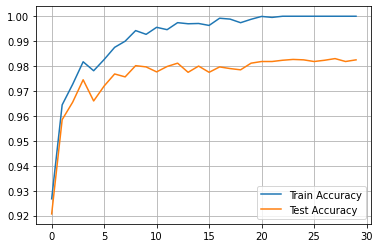

In [ ]:
for epoch in range(num_epochs):
  for x_batch, y_batch in mini_batch(X_train, y_train, batch_size=batch_size, shuffle=True):
    fit(network, x_batch, y_batch)
  
  train_predict = predict(network, X_train)
  train_val = predict(network, X_val)
  
  train_log.append(np.mean(train_predict == y_train))
  val_log.append(np.mean(train_val == y_val))

  print(f"Epoch {epoch}")
  print(f"Train Accuracy: {train_log[-1]}")
  print(f"Test Accuracy: {val_log[-1]}")

plt.plot(train_log, label='Train Accuracy')
plt.plot(val_log, label='Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

Confusion Matrix

In [20]:
def plot_cm(true_y, pred_y):
  c_matrix = confusion_matrix(true_y, pred_y)
  plt.imshow(c_matrix, cmap='Accent')

  for i,j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > (c_matrix.max()/2.0) else "black")

  plt.title("Confusion Matrix")
  plt.ylabel("True values")
  plt.xlabel("Predicted values")

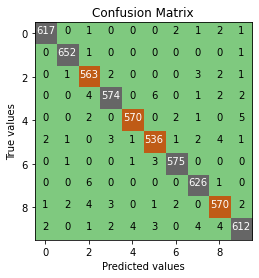

In [ ]:
plot_cm(y_val, train_val)

# Network with Dropout layer

In [16]:
#network
network = []
network.append(DenseLayer(X_train.shape[1],100,learning_rate))
network.append(Relu())
network.append(Dropout(100, 200, learning_rate))
network.append(DenseLayer(200, 100,learning_rate))
network.append(DenseLayer(100, 200,learning_rate))
network.append(Relu())
network.append(DenseLayer(200, 10,learning_rate))

In [17]:
train_log = []
val_log = []



Epoch 0
Train Accuracy: 0.7843703703703704
Test Accuracy: 0.7936666666666666



Epoch 1
Train Accuracy: 0.9482592592592592
Test Accuracy: 0.9383333333333334



Epoch 2
Train Accuracy: 0.9666111111111111
Test Accuracy: 0.9575



Epoch 3
Train Accuracy: 0.9708518518518519
Test Accuracy: 0.9213333333333333



Epoch 4
Train Accuracy: 0.981037037037037
Test Accuracy: 0.9633333333333334



Epoch 5
Train Accuracy: 0.9811666666666666
Test Accuracy: 0.9546666666666667



Epoch 6
Train Accuracy: 0.9839629629629629
Test Accuracy: 0.9671666666666666



Epoch 7
Train Accuracy: 0.9871481481481481
Test Accuracy: 0.963



Epoch 8
Train Accuracy: 0.9887777777777778
Test Accuracy: 0.9675



Epoch 9
Train Accuracy: 0.9904444444444445
Test Accuracy: 0.9601666666666666



Epoch 10
Train Accuracy: 0.9877777777777778
Test Accuracy: 0.951



Epoch 11
Train Accuracy: 0.9911296296296296
Test Accuracy: 0.9548333333333333



Epoch 12
Train Accuracy: 0.9879629629629629
Test Accuracy: 0.9563333333333334



Epoch 13
Train Accuracy: 0.9937407407407407
Test Accuracy: 0.9686666666666667



Epoch 14
Train Accuracy: 0.9879259259259259
Test Accuracy: 0.9635



Epoch 15
Train Accuracy: 0.9915925925925926
Test Accuracy: 0.9615



Epoch 16
Train Accuracy: 0.9927777777777778
Test Accuracy: 0.9685



Epoch 17
Train Accuracy: 0.994462962962963
Test Accuracy: 0.9731666666666666



Epoch 18
Train Accuracy: 0.9950555555555556
Test Accuracy: 0.973



Epoch 19
Train Accuracy: 0.9916296296296296
Test Accuracy: 0.9635



Epoch 20
Train Accuracy: 0.9963888888888889
Test Accuracy: 0.9678333333333333



Epoch 21
Train Accuracy: 0.9894074074074074
Test Accuracy: 0.9606666666666667



Epoch 22
Train Accuracy: 0.9982407407407408
Test Accuracy: 0.9688333333333333



Epoch 23
Train Accuracy: 0.9958333333333333
Test Accuracy: 0.9678333333333333



Epoch 24
Train Accuracy: 0.9939074074074075
Test Accuracy: 0.9658333333333333



Epoch 25
Train Accuracy: 0.9971296296296296
Test Accuracy: 0.9701666666666666



Epoch 26
Train Accuracy: 0.9976666666666667
Test Accuracy: 0.9696666666666667



Epoch 27
Train Accuracy: 0.9967777777777778
Test Accuracy: 0.9735



Epoch 28
Train Accuracy: 0.9954444444444445
Test Accuracy: 0.9688333333333333



Epoch 29
Train Accuracy: 0.995462962962963
Test Accuracy: 0.9648333333333333


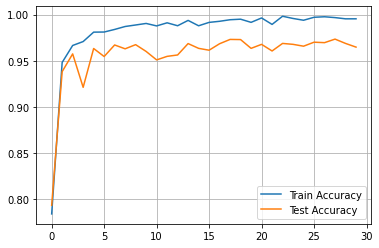

In [18]:
for epoch in range(num_epochs):
  for x_batch, y_batch in mini_batch(X_train, y_train, batch_size=batch_size, shuffle=True):
    fit(network, x_batch, y_batch)
  
  train_predict = predict(network, X_train)
  train_val = predict(network, X_val)
  
  train_log.append(np.mean(train_predict == y_train))
  val_log.append(np.mean(train_val == y_val))

  print(f"Epoch {epoch}")
  print(f"Train Accuracy: {train_log[-1]}")
  print(f"Test Accuracy: {val_log[-1]}")

plt.plot(train_log, label='Train Accuracy')
plt.plot(val_log, label='Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

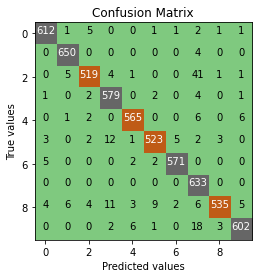

In [21]:
plot_cm(y_val, train_val)

Data Augmentation

In [22]:
from keras.preprocessing.image import ImageDataGenerator

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

gen.fit(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
X_train = X_train/255. 
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
#source: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [23]:
train_log = []
val_log = []



Epoch 0
Train Accuracy: 0.9911851851851852
Test Accuracy: 0.9625



Epoch 1
Train Accuracy: 0.9970555555555556
Test Accuracy: 0.9656666666666667



Epoch 2
Train Accuracy: 0.9974074074074074
Test Accuracy: 0.9646666666666667



Epoch 3
Train Accuracy: 0.9984074074074074
Test Accuracy: 0.9665



Epoch 4
Train Accuracy: 0.9972037037037037
Test Accuracy: 0.9665



Epoch 5
Train Accuracy: 0.9981666666666666
Test Accuracy: 0.972



Epoch 6
Train Accuracy: 0.9974074074074074
Test Accuracy: 0.9681666666666666



Epoch 7
Train Accuracy: 0.998537037037037
Test Accuracy: 0.9718333333333333



Epoch 8
Train Accuracy: 0.9959629629629629
Test Accuracy: 0.9685



Epoch 9
Train Accuracy: 0.9977407407407407
Test Accuracy: 0.9691666666666666



Epoch 10
Train Accuracy: 0.9982962962962963
Test Accuracy: 0.9683333333333334



Epoch 11
Train Accuracy: 0.9987592592592592
Test Accuracy: 0.9736666666666667



Epoch 12
Train Accuracy: 0.9995740740740741
Test Accuracy: 0.9733333333333334



Epoch 13
Train Accuracy: 0.997037037037037
Test Accuracy: 0.969



Epoch 14
Train Accuracy: 0.9997962962962963
Test Accuracy: 0.9698333333333333



Epoch 15
Train Accuracy: 0.9999814814814815
Test Accuracy: 0.9746666666666667



Epoch 16
Train Accuracy: 0.9999814814814815
Test Accuracy: 0.9726666666666667



Epoch 17
Train Accuracy: 0.9999814814814815
Test Accuracy: 0.973



Epoch 18
Train Accuracy: 0.9999814814814815
Test Accuracy: 0.9721666666666666



Epoch 19
Train Accuracy: 0.9999814814814815
Test Accuracy: 0.9738333333333333



Epoch 20
Train Accuracy: 1.0
Test Accuracy: 0.9738333333333333



Epoch 21
Train Accuracy: 1.0
Test Accuracy: 0.9735



Epoch 22
Train Accuracy: 1.0
Test Accuracy: 0.9735



Epoch 23
Train Accuracy: 1.0
Test Accuracy: 0.9738333333333333



Epoch 24
Train Accuracy: 1.0
Test Accuracy: 0.9738333333333333



Epoch 25
Train Accuracy: 1.0
Test Accuracy: 0.9741666666666666



Epoch 26
Train Accuracy: 1.0
Test Accuracy: 0.9738333333333333



Epoch 27
Train Accuracy: 1.0
Test Accuracy: 0.9738333333333333



Epoch 28
Train Accuracy: 1.0
Test Accuracy: 0.9741666666666666



Epoch 29
Train Accuracy: 1.0
Test Accuracy: 0.9741666666666666


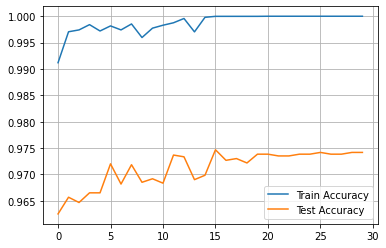

In [24]:
for epoch in range(num_epochs):
  for x_batch, y_batch in mini_batch(X_train, y_train, batch_size=batch_size, shuffle=True):
    fit(network, x_batch, y_batch)
  
  train_predict = predict(network, X_train)
  train_val = predict(network, X_val)
  
  train_log.append(np.mean(train_predict == y_train))
  val_log.append(np.mean(train_val == y_val))

  print(f"Epoch {epoch}")
  print(f"Train Accuracy: {train_log[-1]}")
  print(f"Test Accuracy: {val_log[-1]}")

plt.plot(train_log, label='Train Accuracy')
plt.plot(val_log, label='Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

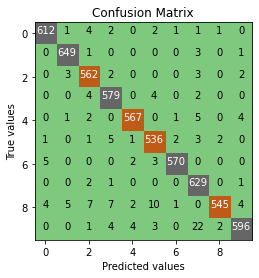

In [25]:
plot_cm(y_val, train_val)